In [87]:
#Liberías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from boruta import BorutaPy

In [88]:
# Yo cargaría el dataframe, para no repetir pasos
df = pd.read_parquet('../data/full_data_initial.parquet')
df

,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_sex,passenger_age,passenger_role,passenger_safety,passenger_type,fatality
0,1999,1,1,20,2.0,34,None,1,5,3,03,06,9.0,1.0,41.0,11,None,1,0
1,1999,1,1,20,2.0,34,None,1,5,3,03,01,12.0,1.0,19.0,11,None,1,0
2,1999,1,1,20,2.0,34,None,1,5,3,03,01,12.0,0.0,20.0,13,02,2,0
3,1999,1,1,8,1.0,01,None,5,3,6,18,01,13.0,1.0,46.0,11,None,1,0
4,1999,1,1,8,1.0,01,None,5,3,6,18,NN,NaN,1.0,5.0,99,None,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850156,2014,12,7,14,2.0,41,01,1,5,1,18,05,6.0,1.0,44.0,11,02,1,0
5850157,2014,12,7,14,2.0,41,01,1,5,1,18,05,6.0,1.0,34.0,13,02,2,0
5850158,2014,12,7,19,1.0,03,01,1,3,4,18,01,13.0,0.0,35.0,11,02,1,0
5850159,2014,12,7,19,1.0,03,01,1,3,4,18,01,13.0,1.0,26.0,13,02,2,0


In [89]:
### HAY QUE MIRAR ESTO. SI LO HACEMOS, CAMBIA LA MORTALIDAD GENERAL DEL DATASET

#TODO:  ¿peatones (df['passenger_role'] == "99")?

# Remove non-driver rows

df = df.loc[(df['passenger_role'] == "11") | (df['passenger_role'] == "99")]

# Drop the role column

df = df.drop('passenger_role', axis = 1)
# por qué hacemos esto? por que el número de personas que van en un coche antes de un accidente no es una variable predecible
# y por lo tanto hemos de tener en cuenta únicamente al conductor, que en un caso hipotético de ponernos en el lugar de una
# empresa aseguradora, será el individuo sobre el cual tendremos información

# Además, nos evita problemas a la hora de entrenar los modelos ya que sería posible que varios registros del mismo coche,
# que inevitablemente tienen una correlación muy alta respecto de la variable objetivo, sesgando nuestros modelos.

In [90]:
df

,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_sex,passenger_age,passenger_safety,passenger_type,fatality
0,1999,1,1,20,2.0,34,None,1,5,3,03,06,9.0,1.0,41.0,None,1,0
1,1999,1,1,20,2.0,34,None,1,5,3,03,01,12.0,1.0,19.0,None,1,0
3,1999,1,1,8,1.0,01,None,5,3,6,18,01,13.0,1.0,46.0,None,1,0
4,1999,1,1,8,1.0,01,None,5,3,6,18,NN,NaN,1.0,5.0,None,3,0
5,1999,1,1,17,3.0,QQ,QQ,1,2,1,01,01,15.0,1.0,28.0,None,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850152,2014,12,7,0,1.0,04,01,2,2,1,18,01,20.0,1.0,49.0,02,1,0
5850153,2014,12,7,18,1.0,02,01,2,5,1,18,01,4.0,1.0,20.0,02,1,0
5850154,2014,12,7,18,1.0,02,01,2,5,1,18,NN,NaN,0.0,81.0,01,3,0
5850156,2014,12,7,14,2.0,41,01,1,5,1,18,05,6.0,1.0,44.0,02,1,0


In [91]:
#TODO: crear columna passenger count si es posible 
#Una forma sería unir tablas por el indice en df está intacto en df2 está reseteado
#Esto solo se podria hacer si partimos del mismo df guardado del descrptive
df2 = pd.read_parquet('../data/vehicle_data_initial.parquet')
df2

,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_type,vehicle_age,fatality,passenger_count
0,1999,1,1,0,1.0,01,01,1,4,1,18,06,8.0,0,1
1,1999,1,1,0,1.0,01,01,1,5,1,18,01,18.0,0,1
2,1999,1,1,0,1.0,01,01,2,1,1,18,01,9.0,0,1
3,1999,1,1,0,1.0,06,01,2,5,3,18,QQ,2.0,0,2
4,1999,1,1,0,2.0,21,02,1,5,1,01,06,10.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043170,2014,12,7,23,2.0,35,01,1,2,1,01,01,1.0,0,2
3043171,2014,12,7,23,2.0,35,01,1,2,1,01,01,6.0,0,1
3043172,2014,12,7,23,3.0,21,02,1,5,1,01,01,15.0,0,4
3043173,2014,12,7,23,3.0,21,02,1,5,1,01,01,16.0,0,2


### Valores Missing

In [92]:
#drop all NAs 
# Deberiamos imputar algunos o no?
null_rows = df.isnull().sum(axis=1).sort_values(ascending=False)
nulos_filas = pd.DataFrame(null_rows, columns=['nulos_filas'])  
nulos_filas['target'] = df['fatality'].copy()
nulos_filas['porcentaje_filas']= nulos_filas['nulos_filas']/df.shape[1]
all_nas = list(nulos_filas.index[nulos_filas.porcentaje_filas>=0.001])
df = df.loc[set(df.index)-set(all_nas)].reset_index()
df.shape

(2703070, 19)

### Outliers

In [93]:
# Remove rows with an outlier vehicle_age
df = df.loc[df['vehicle_age'] < 30]

# Removes rows with outlier vehicles_involved
df = df.loc[df['vehicles_involved'] < 6]

### Tramificación Variable Temporales

In [94]:
#Transform month column to quarters
df['month'] = (df['month']-1)//3 + 1
df = df.rename({'month': 'quarter'}, axis= 1)

In [95]:
# Transform weekday column
df['weekday'] = df['weekday'].replace({6:3, 7:3, 1:2, 4:2, 5:2, 2:1, 3:1})

In [96]:
# Transform hour column
df['hour'] = df['hour'].replace({0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3, 11:4, 12:4, 13:4, 14:4, 15:4, 16:4, 17:4, 18:4, 19:5, 20:5, 21:5, 22:6, 23:6})

### Train Test Split
Al eliminar outliers y missings podemos hacerlo después si quisieramos imputar debereríamos hacerlo antes

In [97]:
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(columns=['fatality']), df['fatality'], test_size=0.25, random_state=0)

In [100]:
xtrain

,index,year,quarter,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_sex,passenger_age,passenger_safety,passenger_type
2056316,4491898,2010,3,2,4,4.0,36,0.008495,1,1,1,01,01,1.0,1.0,67.0,02,1
772375,1748545,2003,1,2,2,2.0,21,0.008495,1,1,1,03,01,1.0,1.0,24.0,02,1
2187134,4772000,2011,3,2,5,2.0,36,0.008495,1,1,1,01,01,6.0,1.0,18.0,QQ,1
1462911,3221380,2007,1,2,4,3.0,21,0.008495,1,1,1,03,01,11.0,0.0,24.0,02,1
1293947,2859277,2006,1,2,6,2.0,33,0.008495,3,2,4,01,01,7.0,1.0,48.0,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268289,4946785,2012,1,1,4,2.0,35,0.008495,4,3,1,18,01,5.0,0.0,36.0,02,1
970852,2174301,2004,2,2,5,1.0,04,0.023447,1,1,4,18,14,1.0,1.0,36.0,09,5
2233608,4872081,2011,4,2,2,2.0,36,0.008495,1,1,1,18,01,2.0,0.0,17.0,02,1
1496490,3290573,2007,1,1,2,2.0,21,0.023447,3,2,1,18,01,5.0,1.0,53.0,02,1


In [101]:
# Mean encoding
encode_cols = ["crash_type", "crash_place", "crash_weather", "surface_state", "road_slope", "traffic_state", "vehicle_type", "passenger_safety", "passenger_type"]

for i in encode_cols:
    encoder = TargetEncoder()
    xtrain[i] = encoder.fit_transform(xtrain[i], ytrain)

for i in encode_cols:
    encoder = TargetEncoder()
    xtest[i] = encoder.fit_transform(xtest[i], ytest)

C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Encoding Variables categóricas

In [77]:
# One-hot-encoding
columnasfecha = ["hour", "weekday", "quarter", "passenger_sex"]

for i in columnasfecha:
    onehotencoder = OneHotEncoder(handle_unknown="ignore")
    array = xtrain[i].values.reshape(-1,1)
    df_temp = onehotencoder.fit_transform(array)
    colnames = onehotencoder.get_feature_names_out([i])
    df_temp = pd.DataFrame(df_temp.toarray(), columns = colnames)
    xtrain.index = df_temp.index
    xtrain = pd.concat([df_temp, xtrain], axis=1)
# We get rid of the not encoded columns
xtrain = xtrain.drop(columns = columnasfecha)
if "passenger_sex_nan" in xtrain.columns:
    xtrain = xtrain.drop(columns = "passenger_sex_nan")

# Same for xtest
for i in columnasfecha:
    onehotencoder = OneHotEncoder(handle_unknown="ignore")
    array = xtest[i].values.reshape(-1,1)
    df_temp = onehotencoder.fit_transform(array)
    colnames = onehotencoder.get_feature_names_out([i])
    df_temp = pd.DataFrame(df_temp.toarray(), columns = colnames)
    xtest.index = df_temp.index
    xtest = pd.concat([df_temp, xtest], axis=1)
xtest = xtest.drop(columns = columnasfecha)
if "passenger_sex_nan" in xtest.columns:
    xtest = xtest.drop(columns = "passenger_sex_nan")

In [59]:
# Intento de loopear el encoding. No funciona, por qué?

# https://www.py4u.net/discuss/161361 tiene que ver! pero la solución no nos vale
frames = [xtest, xtrain]

#for frame in frames:
#    for i in columnasfecha:
#        onehotencoder = OneHotEncoder(handle_unknown="ignore")
#        array = frame[i].values.reshape(-1,1)
#        tempframe = onehotencoder.fit_transform(array)
#        colnames = onehotencoder.get_feature_names_out([i])
#        tempframe = pd.DataFrame(tempframe.toarray(), columns = colnames)
#        frame.index = tempframe.index
#        frame = pd.concat([tempframe, frame], axis=1)

In [85]:
#Reordenamos columnas
new_cols = ['year','quarter_1','quarter_2','quarter_3','quarter_4','weekday_1','weekday_2','weekday_3','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','vehicles_involved','crash_type','crash_place',
            'crash_weather','surface_state','road_slope','traffic_state','vehicle_type','vehicle_age','passenger_age','passenger_sex_0.0','passenger_sex_1.0','passenger_safety','passenger_type','fatality']

### TAMPOCO FUNCIONA
for frame in [xtrain, xtest]:
    frame = frame.reindex(columns=new_cols)

xtrain = xtrain.reindex(columns=new_cols)
xtest = xtest.reindex(columns=new_cols)

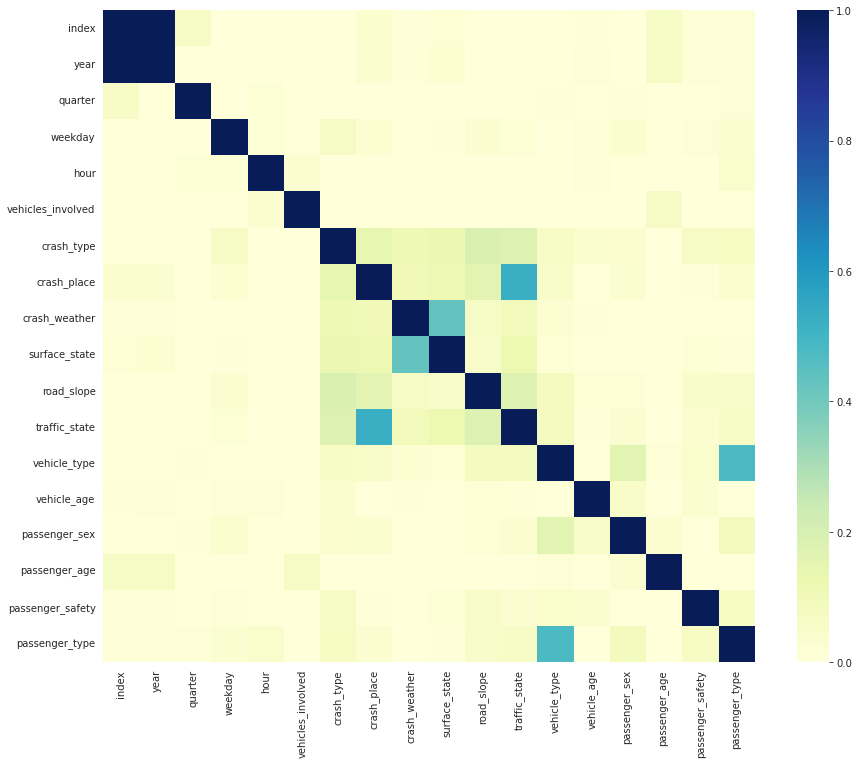

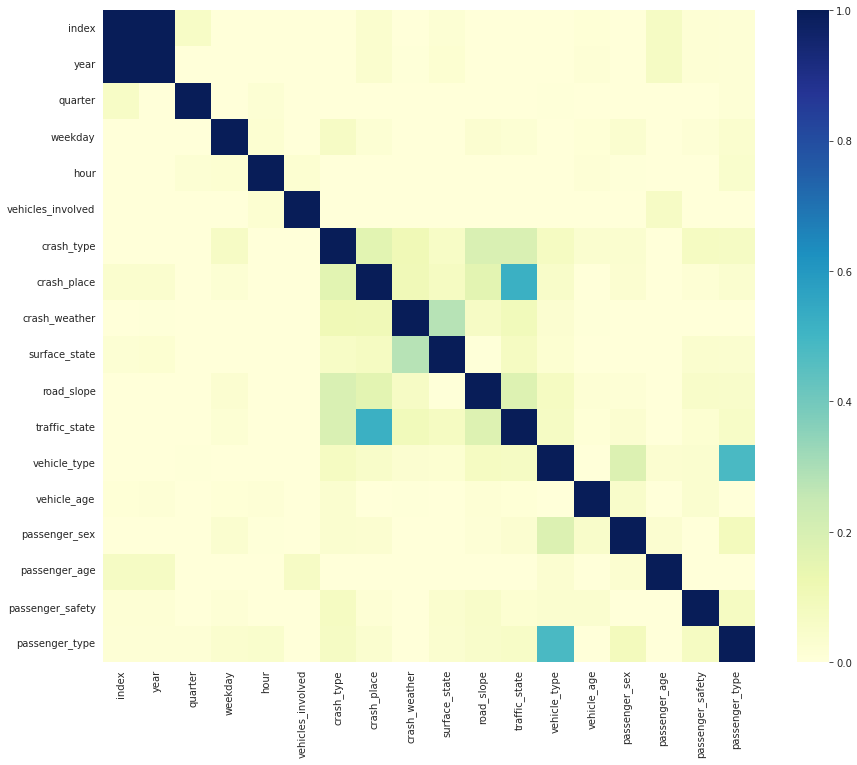

In [103]:
#Correlación de Spearman con todas las variables
  plt.figure(figsize=(15,12))
  with sns.axes_style("white"):
    ax = sns.heatmap(df.corr('spearman'),vmin=0., vmax=1, square=True, cmap="YlGnBu")
  plt.show()

# Selección de Variables

In [ ]:
df.drop(inplace=True, axis=1, columns=['index','level_0'])

In [ ]:
#Guardamos el df
df.to_parquet("../data/full_data_encoded.parquet")

In [ ]:
X = df.drop('fatality', axis = 1)
Y = df.fatality

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=0)

In [ ]:
#Escalado de variables
scaler = StandardScaler()
model_scaled = scaler.fit(xtrain)
xtrain_scaled = pd.DataFrame(scaler.transform(xtrain), columns=xtrain.columns, index=xtrain.index)
xtest_scaled = pd.DataFrame(scaler.transform(xtest), columns=xtest.columns, index=xtest.index)

### Regulariación  Ridge


In [ ]:
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 0.02)
sel_ridge.fit(xtrain_scaled, ytrain)

In [ ]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': xtrain_scaled.columns,
                         'coef': sel_ridge.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

### Algún otro método de slección de variables para comporbar

### Boruta

In [ ]:
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, max_depth=4) # cambiar los hiperparametros

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)

# find all relevant features - 5 features should be selected
feat_selector.fit(xtrain.values, ytrain) # Importante poner el .values al dataframe, sino dará error

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_